In [49]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
from functools import partial

%matplotlib inline
plt.style.use("ggplot")

jax.config.update("jax_enable_x64", True)

In [3]:
%load_ext autoreload
%autoreload 1
%aimport solver.hydro
%aimport solver.solvers
%aimport solver.limiters
%aimport solver.muscl

In [4]:
def imshow(f, size=10, axis=None):
    plt.figure(figsize=(size, size))
    if axis is None:
        extent = None
    else:
        extent = [axis.min(), axis.max(), axis.min(), axis.max()]

    plt.imshow(f, origin="lower", extent=extent)
    plt.colorbar()


def title(e0=1e5, d0=1.0, C=0.5, n=128):
    plt.title("e0={:.0e}   d0={:.0e}   C={:.1f}  n={}".format(e0, d0, C, n))

# Kelvin-Helmholtz

In [5]:
def kelvin_helmholtz_initial_conditions(
    n, L, a=0.05, sigma=0.2, u_flow=1, P0=10, A=0.01
):
    """
    Initialize the conditions for a Kelvin-Helmholtz instability.

    Parameters:
    nx, ny: Grid points in x and y directions
    Lx, Ly: Dimensions of the domain in x and y directions
    rho1, rho2: Densities of the two fluids
    v1, v2: Velocities of the two fluids
    delta: Thickness of the transition layer between the two fluids

    Returns:
    rho: Density field
    vx: Velocity field in x direction
    vy: Velocity field in y direction (initially zero)
    """
    # Create coordinate arrays
    x = jnp.linspace(0, L, n)
    y = jnp.linspace(0, 2 * L, 2 * n)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    y1 = 0.5 * L
    y2 = 1.5 * L

    jump = 0  # delta rho / rho0

    rho = 1 + jump * 0.5 * (jnp.tanh((Y - y1) / a) - jnp.tanh((Y - y2) / a))
    ux = u_flow * (jnp.tanh((Y - y1) / a) - jnp.tanh((Y - y2) / a) - 1)
    uy = (
        A
        * jnp.sin(2 * jnp.pi * X)
        * (jnp.exp(-(((Y - y1) / sigma) ** 2)) + jnp.exp(-(((Y - y2) / sigma) ** 2)))
    )
    c = 0.5 * (jnp.tanh((Y - y2)) - jnp.tanh((Y - y1)) + 2)

    return rho, x, y, ux, uy, c

In [43]:
def create_state(n=1024, L=1.0, gamma=5 / 3, dtype=jnp.float32):
    ds = L / n

    P = jnp.ones((n, 2 * n)) * 10
    rho, x, y, vx, vy, c = kelvin_helmholtz_initial_conditions(n, L)

    total_energy = P / (gamma - 1) + 0.5 * rho * (vx**2 + vy**2)
    state = solver.hydro.HydroState(
        n=n,
        ds=ds,
        dx=ds,
        dy=ds,
        x=dtype(x),
        y=dtype(y),
        density=dtype(rho),
        dye_concentration=dtype(c),
        total_energy=dtype(total_energy),
        momentum_x=dtype(vx * rho),
        momentum_y=dtype(vy * rho),
        adiabatic_index=gamma,
    )

    return state


state = create_state()

In [44]:
state = solver.hydro.load_state("kh_2048-01.pkl")

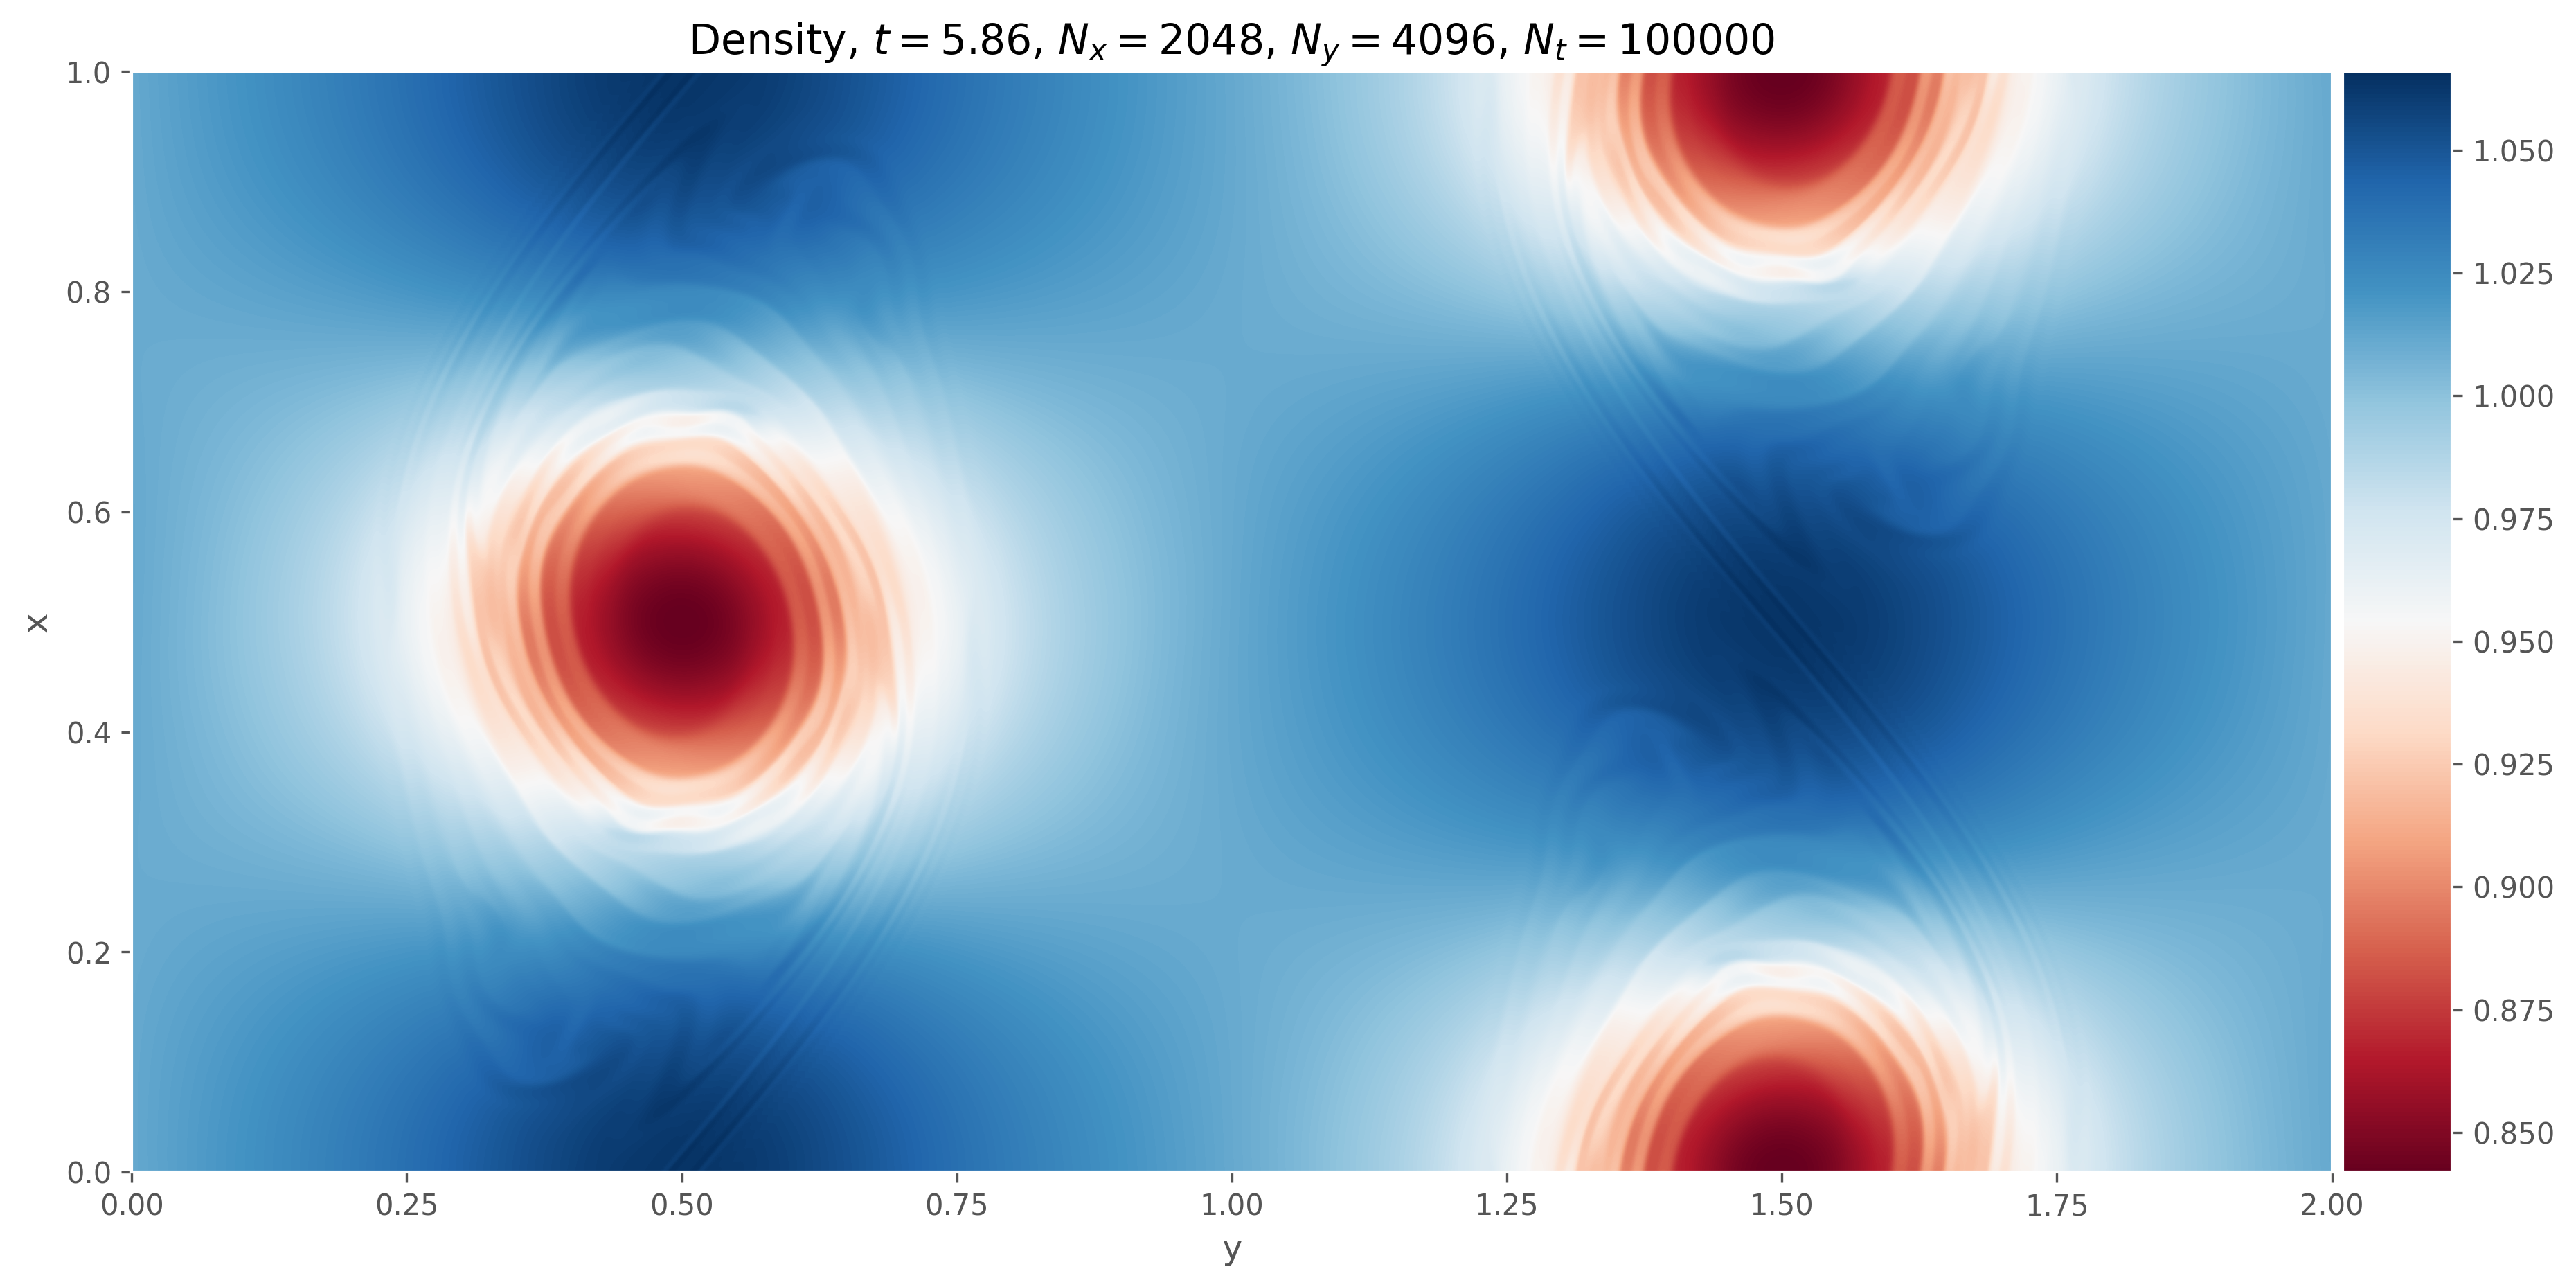

In [47]:
def show_state(state, varname="dye_concentration", cmap="viridis"):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    extent = [state.y.min(), state.y.max(), state.x.min(), state.x.max()]
    labelname = varname.replace("_", " ").capitalize()
    nx = state.x.size
    ny = state.y.size
    aspect_ratio = nx / ny
    title = f"{labelname}, $t={state.t:.2f}$, $N_x={nx}$, $N_y={ny}$, $N_t={state.it}$"

    fig, ax = plt.subplots(dpi=300)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.set_size_inches(25 * aspect_ratio, 25 / aspect_ratio)

    im = ax.imshow(getattr(state, varname), origin="lower", extent=extent, cmap=cmap)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.set_title(title)
    ax.grid(False)

    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()
    

show_state(state, varname="density", cmap="RdBu")
plt.savefig("kh_2048-density.pdf", bbox_inches="tight")

In [10]:
from tqdm import trange

def run_kelvin_helmholtz(n=1024, nt=100, C=0.5, dtype=jnp.float32):
    jax.config.update("jax_debug_nans", False)

    riemann_solver = solver.solvers.local_lax_friedrichs
    slope_limiter = solver.limiters.monotonized_central
    state = create_state(n=n, dtype=dtype)
    start = time()

    with trange(int(nt), desc="MUSCL 2D") as pbar:
        for i in pbar:
            pbar.set_postfix({"t": f"{state.t:.3f}"})
            state = solver.muscl.muscl_2d(
                state,
                C,
                slope_limiter=slope_limiter,
                riemann_solver=riemann_solver,
                enable_dye=True,
            )

    used = time() - start

    print(
        "total: {:.1f} sec, {:.2f} microseconds/update".format(
            used, 1e6 * used / (n**2 * nt)
        )
    )

    return state



In [ ]:

state = run_kelvin_helmholtz(n=4096, nt=200000, C=0.5)
solver.hydro.save_state(state, "kh_4096-200k-f32.pkl.xz")
show_state(state, "density")

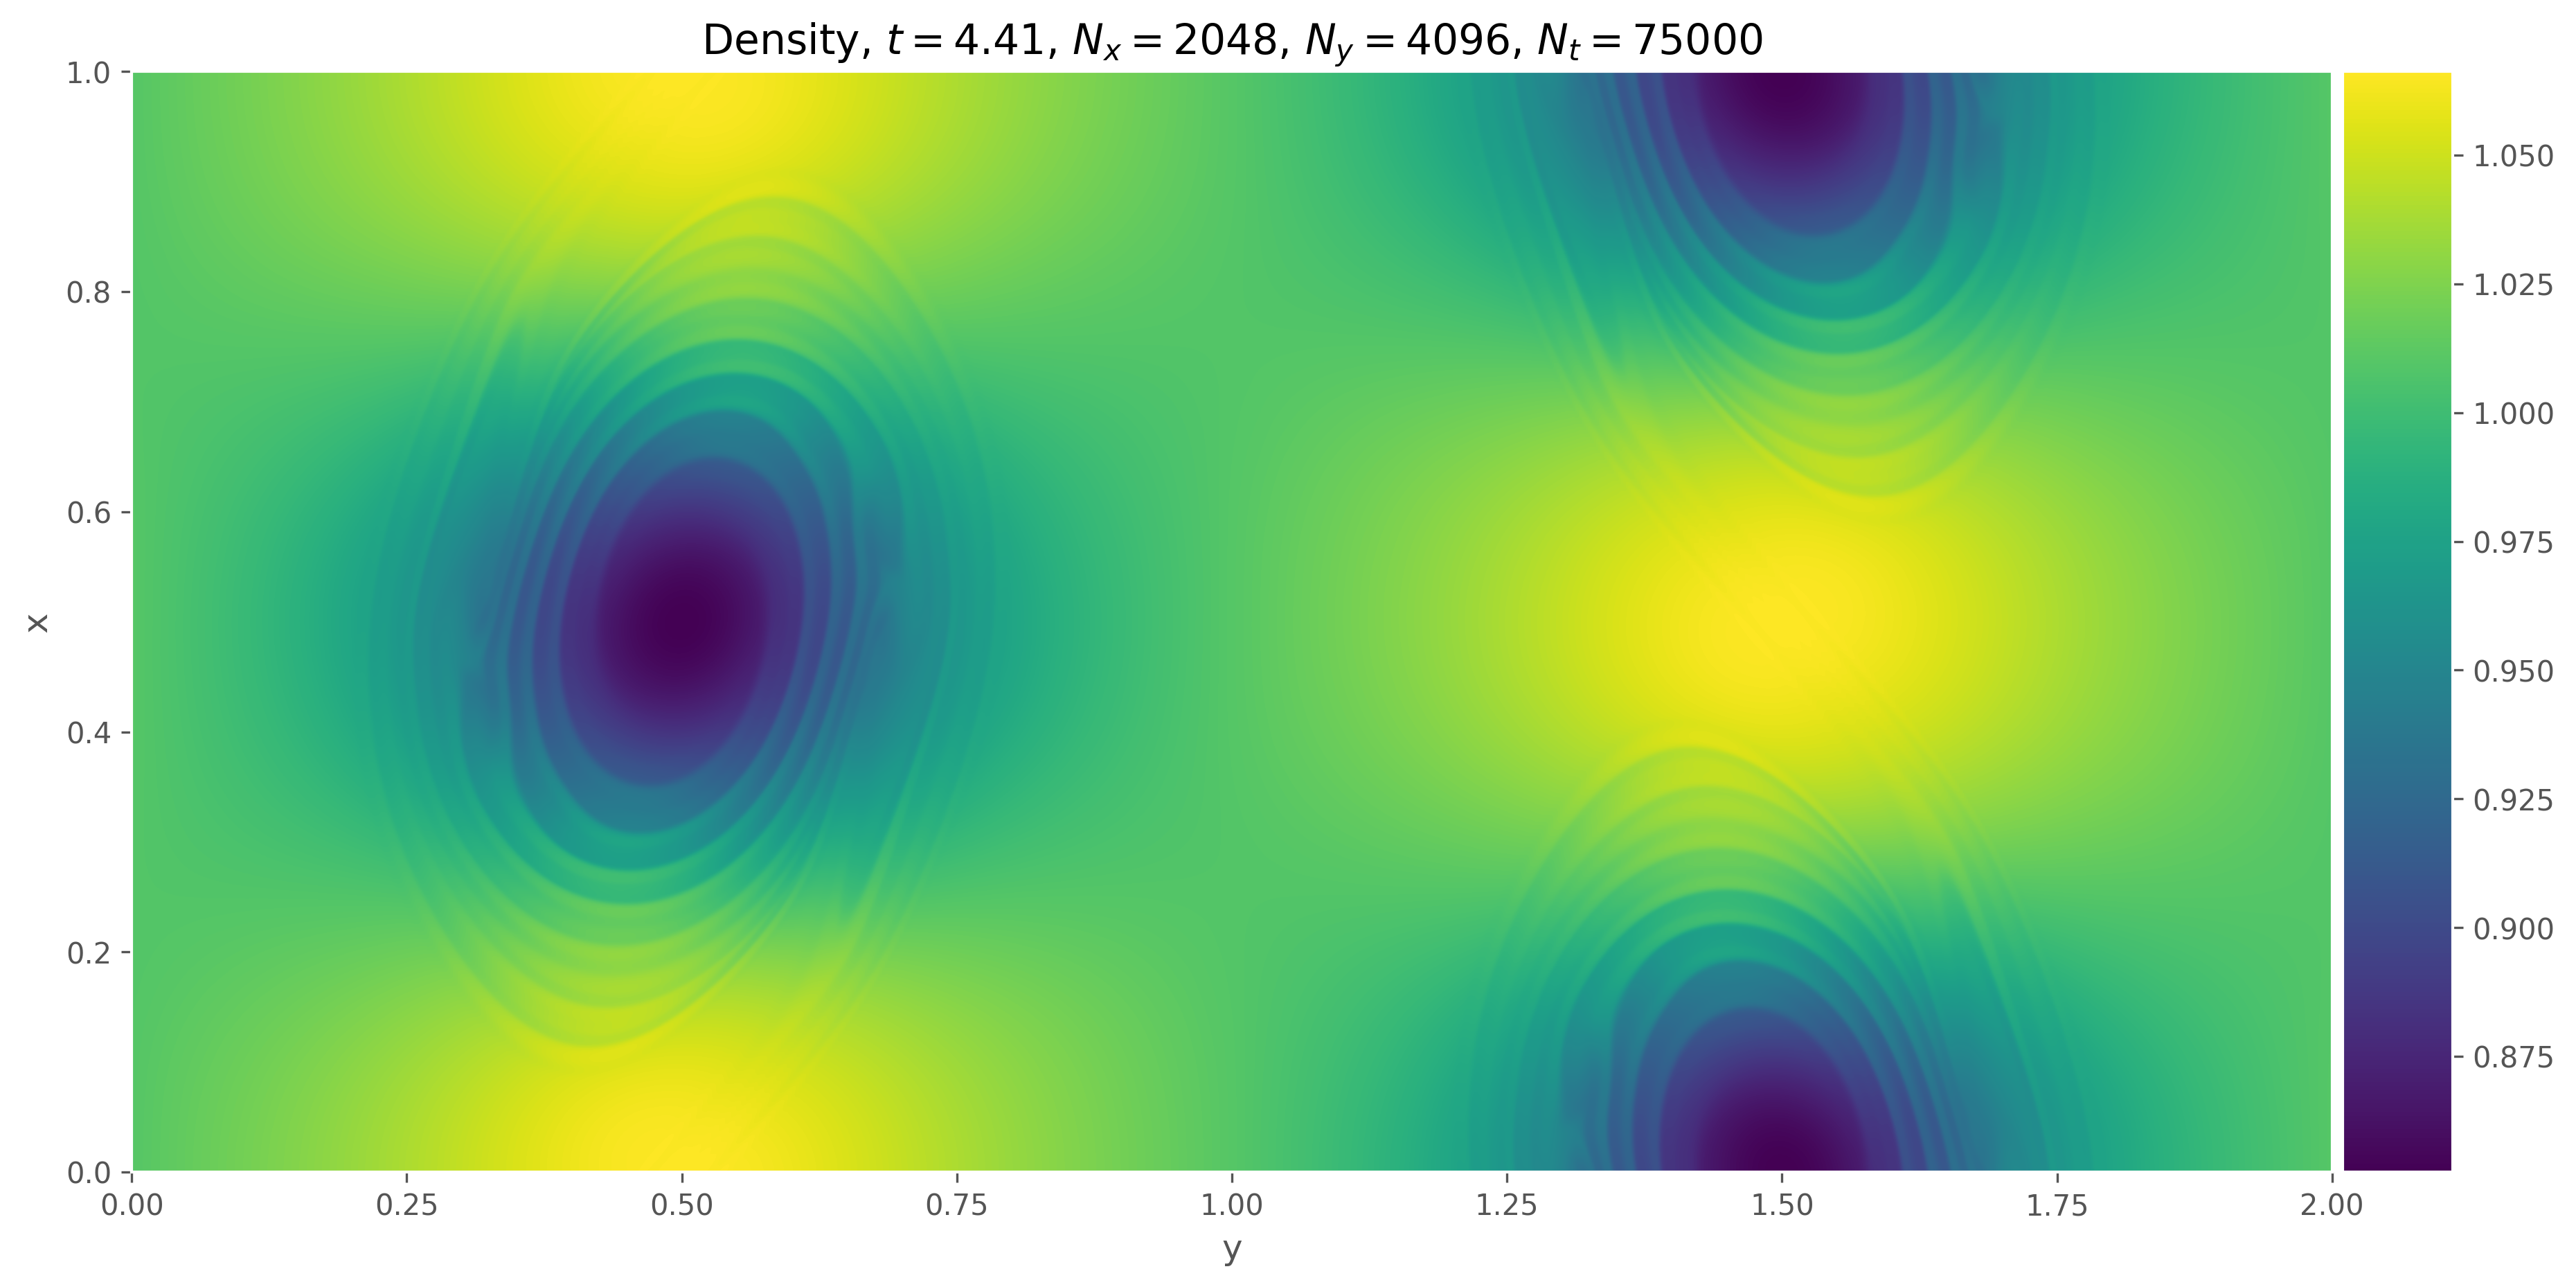

In [ ]:
# solver.hydro.save_state(state, "kh_2048.pkl")
show_state(state, "density")
plt.savefig("kh_density.pdf")

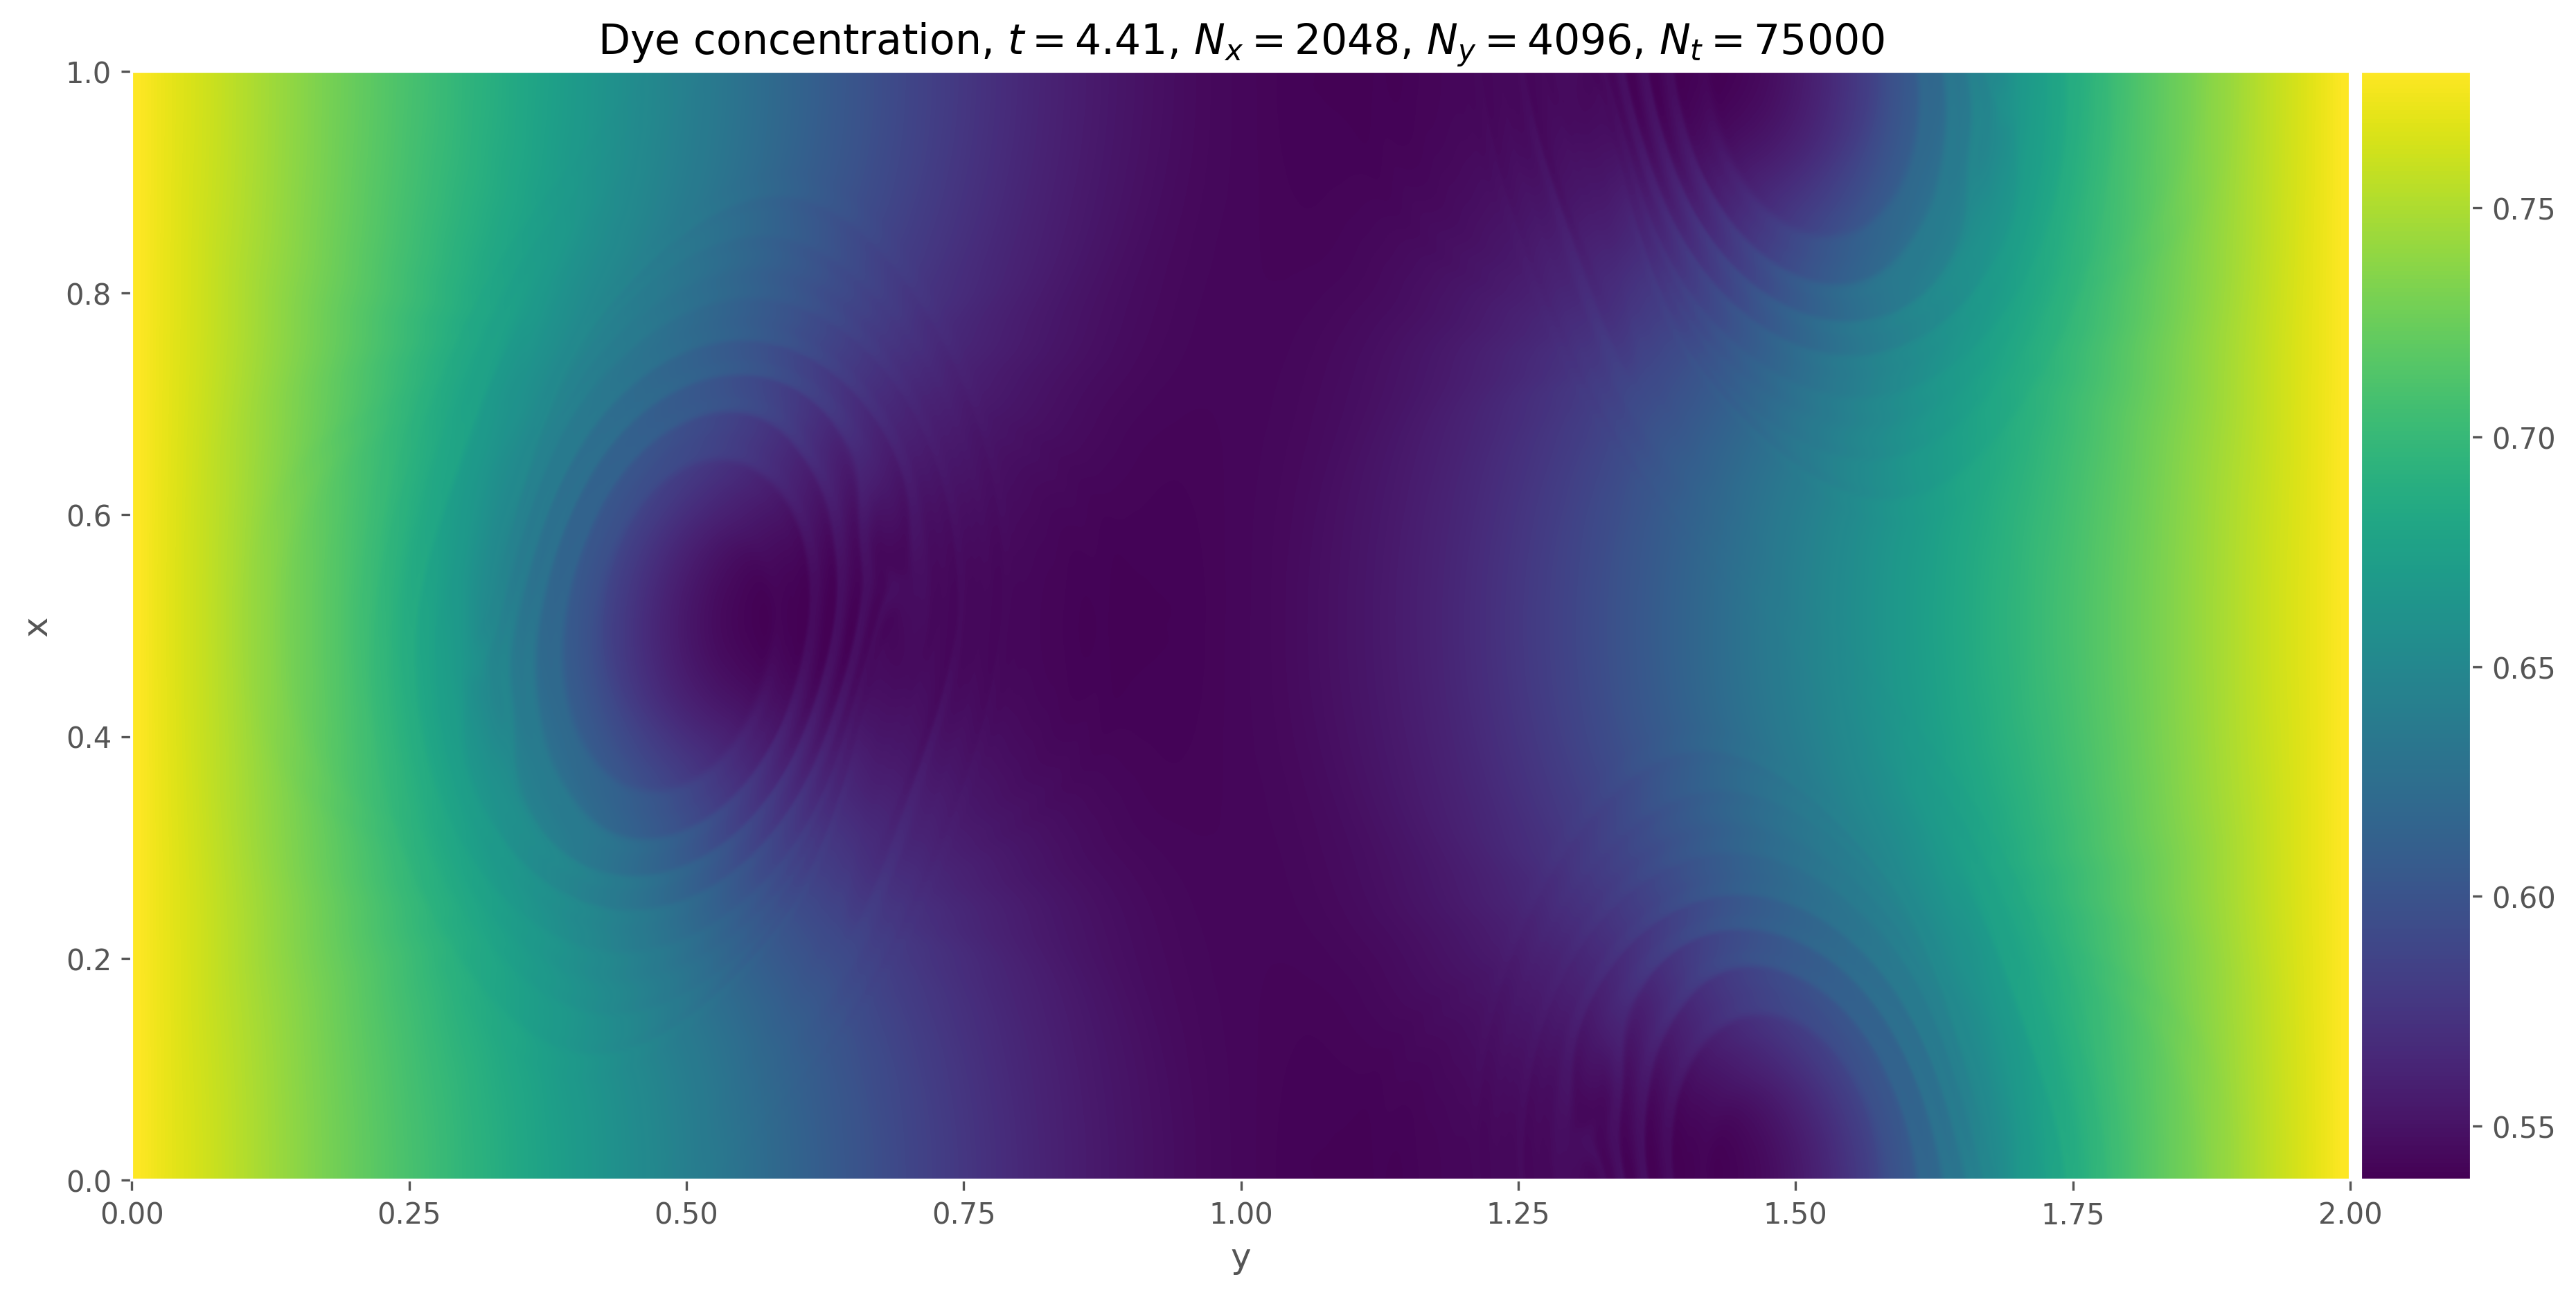

In [ ]:
show_state(state, "dye_concentration")

MUSCL 2D: 100%|██████████| 25000/25000 [00:35<00:00, 713.98it/s, t=5.869]


total: 35.0 sec, 0.01 microseconds/update


MUSCL 2D: 100%|██████████| 50000/50000 [01:08<00:00, 726.29it/s, t=11.647]


total: 68.8 sec, 0.01 microseconds/update


MUSCL 2D: 100%|██████████| 75000/75000 [01:44<00:00, 715.45it/s, t=17.417]


total: 104.8 sec, 0.01 microseconds/update


MUSCL 2D: 100%|██████████| 25000/25000 [01:10<00:00, 355.50it/s, t=2.977]


total: 70.3 sec, 0.00 microseconds/update


MUSCL 2D: 100%|██████████| 50000/50000 [02:18<00:00, 361.04it/s, t=5.863]


total: 138.5 sec, 0.00 microseconds/update


MUSCL 2D: 100%|██████████| 75000/75000 [03:27<00:00, 360.69it/s, t=8.749]


total: 207.9 sec, 0.00 microseconds/update


MUSCL 2D: 100%|██████████| 25000/25000 [04:09<00:00, 100.15it/s, t=1.547]


total: 249.6 sec, 0.00 microseconds/update


MUSCL 2D: 100%|██████████| 50000/50000 [08:02<00:00, 103.70it/s, t=2.976]


total: 482.2 sec, 0.00 microseconds/update


MUSCL 2D: 100%|██████████| 75000/75000 [12:03<00:00, 103.72it/s, t=4.415]


total: 723.1 sec, 0.00 microseconds/update


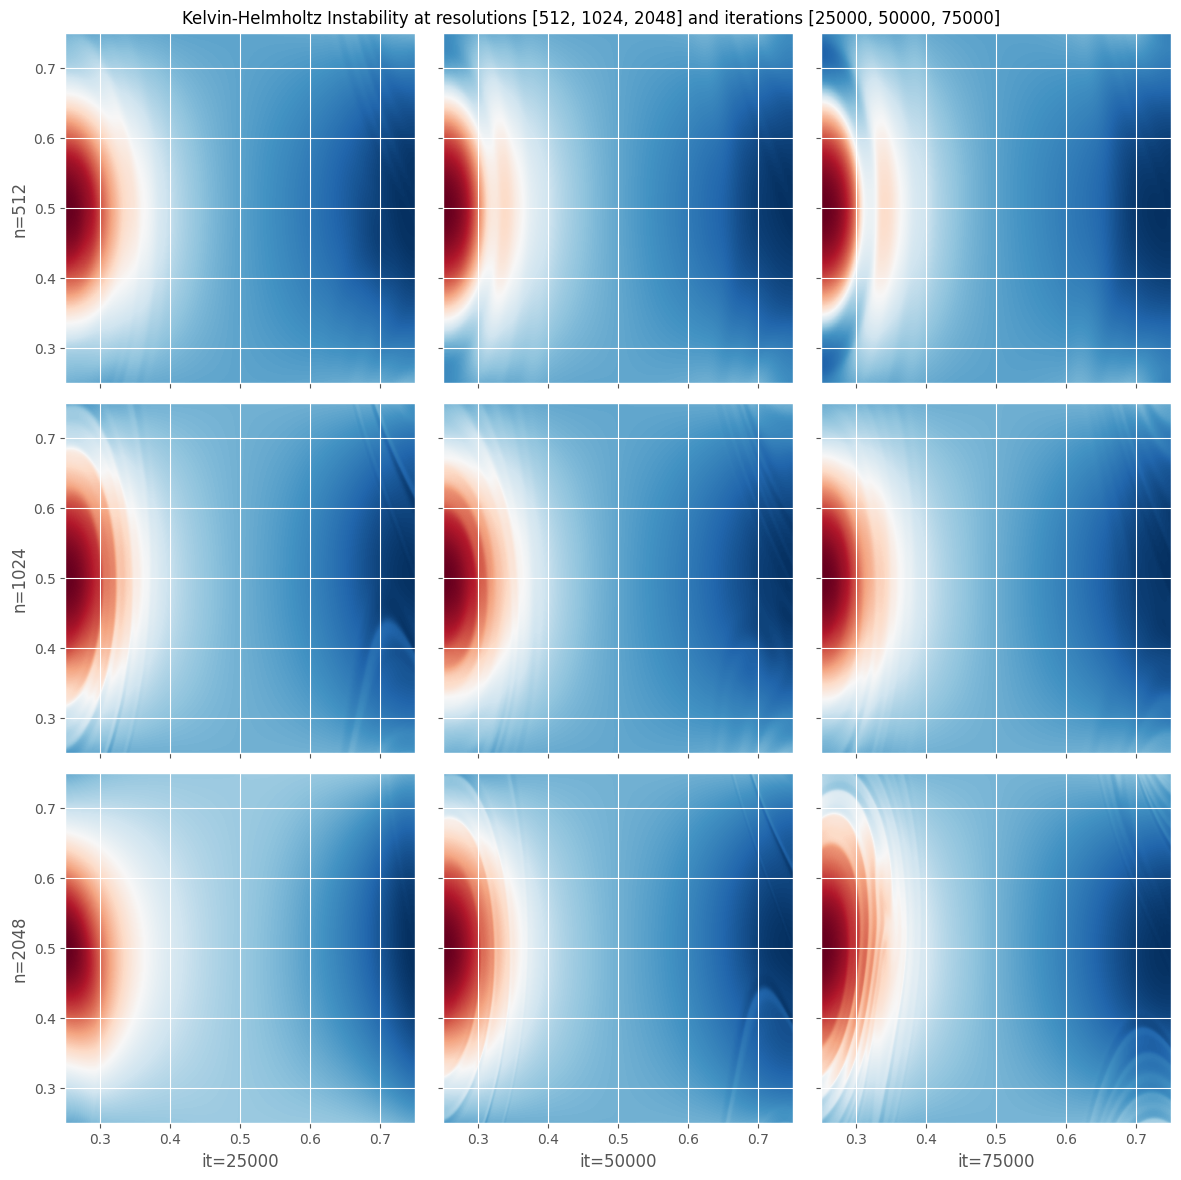

In [23]:
def composite_plot(its=[25000, 50000, 75000], res=[512, 1024, 2048]):
    """
    Run a kelvin helmholtz instability simulation with different resolutions.
    Plot the density at different numbers of iterations its,
    and resolutions res, in composite plot with shared axes.
    The parameters are shown on the outer axes.
    """

    fig, axs = plt.subplots(
        nrows=len(res),
        ncols=len(its),
        figsize=(4 * len(its), 4 * len(res)),
        sharex=True,
        sharey=True,
    )

    for i, n in enumerate(res):
        for j, it in enumerate(its):
            state = run_kelvin_helmholtz(n=n, nt=it, C=0.5)
            ax = axs[i, j]
            ax.imshow(state.density, origin="lower", cmap="RdBu")
            ax.set_xlim([0.25, 0.75])
            ax.set_ylim([0.25, 0.75])

            if i == len(res) - 1:
                ax.set_xlabel(f"it={it}")
            if j == 0:
                ax.set_ylabel(f"n={n}")

    plt.tight_layout()

MUSCL 2D:  70%|███████   | 17532/25000 [03:10<01:21, 91.81it/s, t=1.094] 


KeyboardInterrupt: 

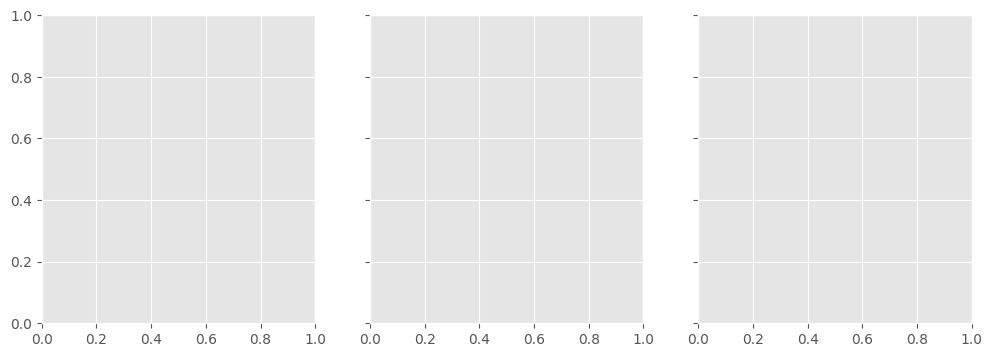

In [48]:

composite_plot(res=[2048])
fig.suptitle(f"Kelvin-Helmholtz Instability at resolution 2048 and iterations {its}")
plt.savefig(f"kh_res2048_composite.pdf")


# Scaling

In [78]:
def benchmark_muscl_2d(p_min=1, p_max=6, nt=100, repeats=3, dtypes=[jnp.float32, jnp.float64]) -> pd.DataFrame:
    """
    Benchmark the MUSCL 2D solver for Kelvin-Helmholtz instability.
    Run the solver for different resolutions and measure the time taken.
    Return the average time per cell update in microseconds.
    """

    results = []

    for dtype in dtypes:
        for p in range(p_min, p_max + 1):
            n = 2**p

            times = []

            for i in range(repeats + 1):
                state = create_state(n=n, dtype=dtype)
                
                start = time()
                state = run_kelvin_helmholtz(n=n, nt=nt, C=0.5, dtype=dtype)
                used = time() - start

                if i == 0:
                    continue

                times.append(used)

            used = sum(times) / repeats
            dtype_name = dtype.__name__.split(".")[-1]

            results.append({"n": n, "dtype": dtype_name, "time": used})

    df = pd.DataFrame(results)
    df["time_per_cell"] = 1e6 * df["time"] / (df["n"] * nt)

    return df

bench_results = benchmark_muscl_2d(p_max=8, nt=1000, repeats=3)

MUSCL 2D:   0%|          | 0/1000 [00:00<?, ?it/s, t=1.966]

MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1519.83it/s, t=84.669]


total: 0.7 sec, 164.87 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1092.98it/s, t=84.669]


total: 0.9 sec, 229.01 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1046.72it/s, t=84.669]


total: 1.0 sec, 239.24 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1072.96it/s, t=84.669]


total: 0.9 sec, 233.48 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1032.34it/s, t=41.711]


total: 1.0 sec, 60.67 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1043.29it/s, t=41.711]


total: 1.0 sec, 60.00 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1074.53it/s, t=41.711]


total: 0.9 sec, 58.25 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 977.08it/s, t=41.711]


total: 1.0 sec, 64.02 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1014.46it/s, t=19.095]


total: 1.0 sec, 15.44 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1285.75it/s, t=19.095]


total: 0.8 sec, 12.18 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1823.63it/s, t=19.095]


total: 0.5 sec, 8.58 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1838.87it/s, t=19.095]


total: 0.5 sec, 8.51 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1588.97it/s, t=8.093]


total: 0.6 sec, 2.46 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1066.85it/s, t=8.093]


total: 0.9 sec, 3.67 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 922.05it/s, t=8.093]


total: 1.1 sec, 4.24 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1285.80it/s, t=8.093]


total: 0.8 sec, 3.04 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1094.62it/s, t=3.991]


total: 0.9 sec, 0.89 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 953.12it/s, t=3.991]


total: 1.1 sec, 1.03 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1043.41it/s, t=3.991]


total: 1.0 sec, 0.94 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1075.12it/s, t=3.991]


total: 0.9 sec, 0.91 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1275.58it/s, t=1.978]


total: 0.8 sec, 0.19 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1554.27it/s, t=1.978]


total: 0.6 sec, 0.16 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1016.73it/s, t=1.978]


total: 1.0 sec, 0.24 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1110.90it/s, t=1.978]


total: 0.9 sec, 0.22 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1049.00it/s, t=0.999]


total: 1.0 sec, 0.06 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1008.62it/s, t=0.999]


total: 1.0 sec, 0.06 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1063.16it/s, t=0.999]


total: 0.9 sec, 0.06 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1020.89it/s, t=0.999]


total: 1.0 sec, 0.06 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1022.03it/s, t=0.500]


total: 1.0 sec, 0.01 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1138.77it/s, t=0.500]


total: 0.9 sec, 0.01 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 966.15it/s, t=0.500]


total: 1.0 sec, 0.02 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 964.26it/s, t=0.500]


total: 1.0 sec, 0.02 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 972.76it/s, t=84.668]


total: 1.0 sec, 257.42 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1092.14it/s, t=84.668]


total: 0.9 sec, 229.41 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1011.71it/s, t=84.668]


total: 1.0 sec, 247.48 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1029.40it/s, t=84.668]


total: 1.0 sec, 243.23 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1427.28it/s, t=41.711]


total: 0.7 sec, 43.89 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1011.18it/s, t=41.711]


total: 1.0 sec, 61.92 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1470.35it/s, t=41.711]


total: 0.7 sec, 42.61 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1119.36it/s, t=41.711]


total: 0.9 sec, 55.92 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1075.89it/s, t=19.095]


total: 0.9 sec, 14.55 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1038.24it/s, t=19.095]


total: 1.0 sec, 15.08 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1023.63it/s, t=19.095]


total: 1.0 sec, 15.29 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1015.22it/s, t=19.095]


total: 1.0 sec, 15.42 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1065.49it/s, t=8.093]


total: 0.9 sec, 3.67 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1556.15it/s, t=8.093]


total: 0.6 sec, 2.51 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1380.38it/s, t=8.093]


total: 0.7 sec, 2.83 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1080.11it/s, t=8.093]


total: 0.9 sec, 3.62 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1023.18it/s, t=3.991]


total: 1.0 sec, 0.96 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1020.82it/s, t=3.991]


total: 1.0 sec, 0.96 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1244.61it/s, t=3.991]


total: 0.8 sec, 0.79 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 962.43it/s, t=3.991]


total: 1.0 sec, 1.02 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 969.18it/s, t=1.978]


total: 1.0 sec, 0.25 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 982.11it/s, t=1.978]


total: 1.0 sec, 0.25 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:00<00:00, 1014.63it/s, t=1.978]


total: 1.0 sec, 0.24 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 921.38it/s, t=1.978]


total: 1.1 sec, 0.27 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 878.71it/s, t=0.999]


total: 1.1 sec, 0.07 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 983.43it/s, t=0.999]


total: 1.0 sec, 0.06 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 969.51it/s, t=0.999]


total: 1.0 sec, 0.06 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 912.63it/s, t=0.999]


total: 1.1 sec, 0.07 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 646.55it/s, t=0.500]


total: 1.5 sec, 0.02 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 644.12it/s, t=0.500]


total: 1.6 sec, 0.02 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 614.16it/s, t=0.500]


total: 1.6 sec, 0.02 microseconds/update


MUSCL 2D: 100%|██████████| 1000/1000 [00:01<00:00, 625.82it/s, t=0.500]


total: 1.6 sec, 0.02 microseconds/update


<Axes: xlabel='n', ylabel='time'>

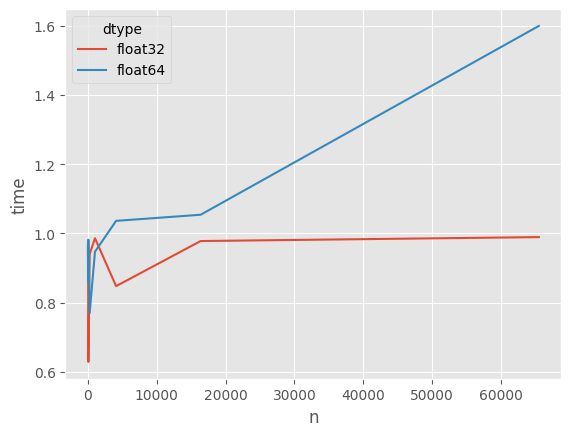

In [79]:
sns.lineplot(data=bench_results, x="n", y=, hue="dtype")